In [1]:
import torch
import torch.nn as nn
from torchvision.models import ResNet34_Weights
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Resize, CenterCrop
from torchvision.transforms import v2
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#Downloading the model
file_id = 'https://drive.google.com/file/d/1EtD0IW-mGIdNAyVX90UjLGKO-GfZSK6a/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/model.zip
!unzip -q $destination_dir/model.zip -d $destination_dir

Downloading...
From: https://drive.google.com/uc?id=1EtD0IW-mGIdNAyVX90UjLGKO-GfZSK6a
To: /content/model.zip
100% 79.0M/79.0M [00:00<00:00, 80.7MB/s]


In [3]:
# function using model to extract feature + label tensors from dataset
def extract_features(model, loader, device):
    # set model to evaluation mode
    model.eval()

    features, labels = [], []

    # gradients not needed for inference
    with torch.no_grad():
        for image, label in tqdm(loader, desc="Extracting features"):
            # Forward pass through the model
            image = image.to(device)
            label = label.to(device)
            features_batch = model(image)
            # Flatten the features
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch.cpu())
            labels.append(label)

    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

# function to create model pretrained on ImageNet only
def ImageNetModel(device):
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    model = model.to(device)
    return model

# function to find and plot KL divergence for a range of perplexity values
def find_perplexity(features, min_perplexity, max_perplexity, step, num_components):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    # array of perplexity values to test
    perplexity = np.arange(min_perplexity, max_perplexity, step)

    divergence = []

    # find the KL divergence for each perplexity value
    for i in perplexity:
        model = TSNE(n_components=num_components, init="pca", perplexity=i)
        reduced = model.fit_transform(features_np)
        divergence.append(model.kl_divergence_)

    # plot divergence
    fig = px.line(x=perplexity, y=divergence, markers=True)
    fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
    fig.update_traces(line_color="red", line_width=1)
    fig.show()

# function to perform tsne on features extracted and visualize results
def perform_tsne(features, perplexity, labels, title):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    labels = labels.cpu()

    # perform tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # plot results
    fig, ax = plt.subplots()
    scatter = ax.scatter(x=features_tsne[:, 0], y=features_tsne[:, 1], c=labels, alpha=0.3)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend1)
    plt.title(title)
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load custom model
model1 = resnet34(num_classes=3).to(device)
model1.load_state_dict(torch.load("model.pth", map_location=device))

# load ImageNet model
model2 = ImageNetModel(device)

models = {
    # remove final classification layer in each model
    "Custom Model": nn.Sequential(*list(model1.children())[:-1]),
    "ImageNet Model": nn.Sequential(*list(model2.children())[:-1])
}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 47.6MB/s]


In [6]:
#Downloading the datasets 2 and 3
file_id = 'https://drive.google.com/file/d/1zzl5T2dTmDJsJFWg-WINNaBu3eM_-Fa_/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/dataset2.zip
!unzip -q $destination_dir/dataset2.zip -d $destination_dir


file_id = 'https://drive.google.com/file/d/1a_ugP7MB2Ykf_2WaNkDgWMVpF2zRA-HS/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/dataset3.zip
!unzip -q $destination_dir/dataset3.zip -d $destination_dir

Downloading...
From: https://drive.google.com/uc?id=1zzl5T2dTmDJsJFWg-WINNaBu3eM_-Fa_
To: /content/dataset2.zip
100% 123M/123M [00:01<00:00, 66.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a_ugP7MB2Ykf_2WaNkDgWMVpF2zRA-HS
To: /content/dataset3.zip
100% 278M/278M [00:03<00:00, 74.5MB/s]


In [7]:
# define transformations according to ImageNet preprocessing
ImageNet_transform = v2.Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define transformations according to custom model's preprocessing
custom_transform = v2.Compose([
    ToTensor(),
    Normalize([0.7621, 0.5239, 0.7111], [0.0066, 0.0096, 0.0063])
])

# load transformed Dataset 2 and 3 for each model
data_loaders = {
    "Custom Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='Dataset 2/Prostate Cancer', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='Dataset 3/Animal Faces', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4)
    },
    "ImageNet Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='Dataset 2/Prostate Cancer', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='Dataset 3/Animal Faces', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4)
    },
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# apply feature extractionfor 4 scenarios
# custom model on Dataset 2, custom model on Dataset 3
# ImageNet model on Dataset 2, ImageNet model on Dataset 3
extracted_features = {}
for model_name, model in models.items():
    for dataset_name, dataloader in data_loaders[model_name].items():
        features, labels = extract_features(model, dataloader, device)
        key = model_name + "_" + dataset_name
        extracted_features[key] = {
            "features" : features,
            "labels" : labels
        }

Extracting features: 100%|██████████| 94/94 [16:01<00:00, 10.23s/it]


In [21]:
X = extracted_features["Custom Model_Prostate Cancer"]["features"].detach().cpu().numpy()
y = extracted_features["Custom Model_Prostate Cancer"]["labels"].detach().cpu().numpy()
Cancer_Classes = ["Gland", "NonGland", "Tumour"]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

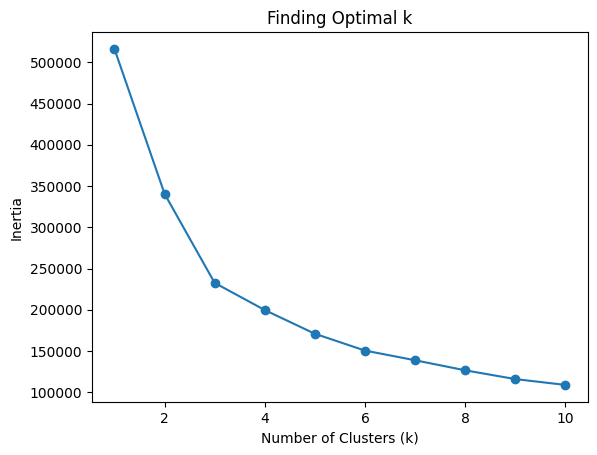

In [23]:
from sklearn.cluster import KMeans

# Define a range of k values to try
k_values = range(1, 11)

# List to store the inertia (sum of squared distances to the closest centroid) for each k
inertia_values = []

# Iterate through different values of k
for k in k_values:
    # Create and fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)

    # Append the inertia value to the list
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Finding Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02      1380
           1       0.47      0.92      0.62      1398
           2       0.23      0.03      0.05      1422

    accuracy                           0.32      4200
   macro avg       0.24      0.32      0.23      4200
weighted avg       0.24      0.32      0.23      4200



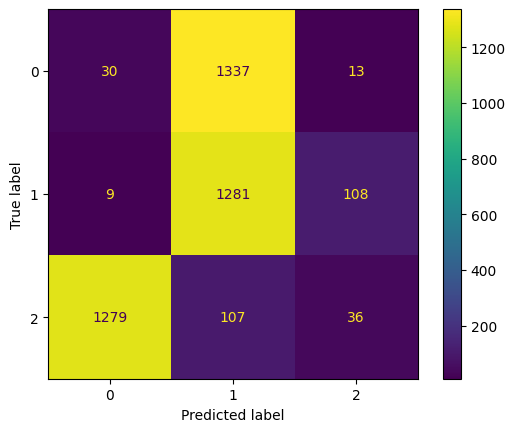

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# Using the optimal number of clusters for kMeans
optimal_k = 3

# Create and fit the KMeans model on the entire dataset
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X)

# Split the data into training and testing sets
X_train_clustered, X_test_clustered, cluster_labels_train, cluster_labels_test = train_test_split(
    X, cluster_labels, test_size=0.3, random_state=109
)

# Confusion matrix and display for training set
cm_train = confusion_matrix(y_train, kmeans.predict(X_train_clustered))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()

# Classification report for training set
print("Classification Report for Training Set:")
print(classification_report(y_train, kmeans.predict(X_train_clustered)))
plt.show()


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       620
           1       0.46      0.91      0.61       602
           2       0.19      0.02      0.04       578

    accuracy                           0.32      1800
   macro avg       0.22      0.32      0.23      1800
weighted avg       0.22      0.32      0.23      1800



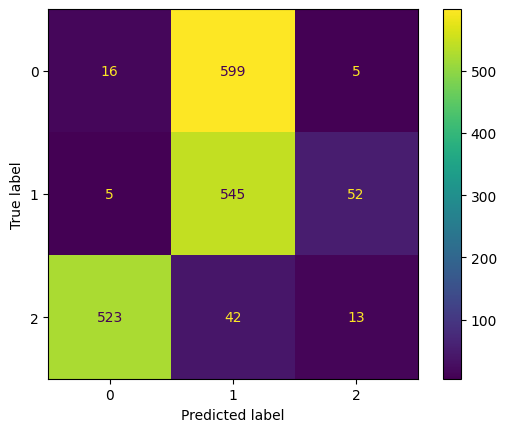

In [29]:
# Confusion matrix and display for test set
cm_test = confusion_matrix(y_test, kmeans.predict(X_test_clustered))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

# Classification report for test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, kmeans.predict(X_test_clustered)))
plt.show()

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.49      0.97      0.65      1380
           1       0.68      0.08      0.15      1398
           2       0.97      0.90      0.93      1422

    accuracy                           0.65      4200
   macro avg       0.72      0.65      0.58      4200
weighted avg       0.72      0.65      0.58      4200



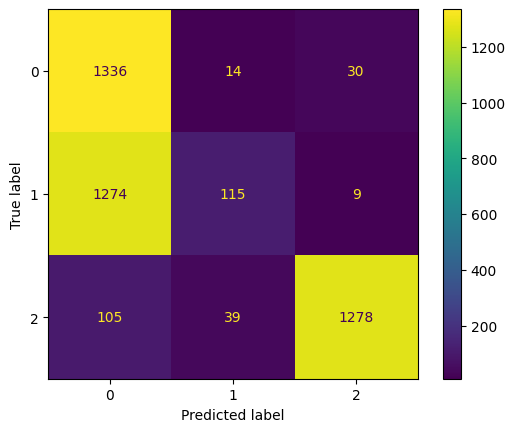

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score
from scipy.optimize import linear_sum_assignment


# Using the optimal number of clusters for kMeans
optimal_k = 3

# Create and fit the KMeans model on the entire dataset using the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X)

cluster_train_labels = kmeans.fit_predict(X_train)

# Use the Hungarian algorithm to relabel training dataset clusters
cost_matrix = -confusion_matrix(y_train, cluster_train_labels)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
relabeled_train_labels = np.zeros_like(cluster_train_labels)
for true_label, cluster_label in zip(row_ind, col_ind):
    relabeled_train_labels[cluster_train_labels == cluster_label] = true_label

# Confusion matrix and display for training set
cm_train = confusion_matrix(y_train, relabeled_train_labels)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()

# Classification report for training set
print("Classification Report for Training Set:")
print(classification_report(y_train, relabeled_train_labels))
plt.show()


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.50      0.97      0.66       620
           1       0.75      0.08      0.14       602
           2       0.96      0.90      0.93       578

    accuracy                           0.65      1800
   macro avg       0.74      0.65      0.58      1800
weighted avg       0.73      0.65      0.57      1800



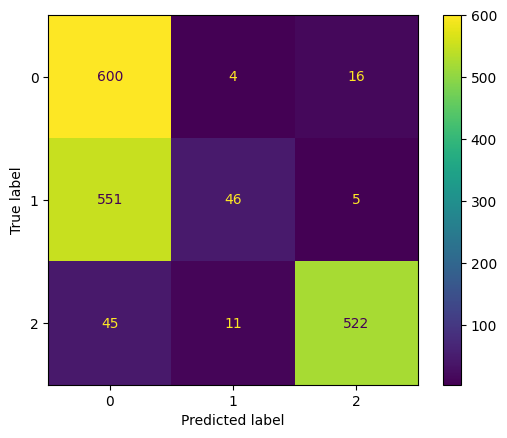

In [27]:
cluster_test_labels = kmeans.fit_predict(X_test)

# Use the Hungarian algorithm to relabel test dataset clusters
cost_matrix = -confusion_matrix(y_test, cluster_test_labels)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
relabeled_test_labels = np.zeros_like(cluster_test_labels)
for true_label, cluster_label in zip(row_ind, col_ind):
    relabeled_test_labels[cluster_test_labels == cluster_label] = true_label

# Confusion matrix and display for test set
cm_test = confusion_matrix(y_test, relabeled_test_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

# Classification report for test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, relabeled_test_labels))
plt.show()